In [0]:
from __future__ import print_function, division
import os
import torch
from torch.optim.optimizer import Optimizer
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

from torch.utils.tensorboard import SummaryWriter

import PIL
from PIL import Image

from google.colab import output

In [2]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

num_of_classes = 3

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 4111 (delta 34), reused 120 (delta 29), pack-reused 3985
Receiving objects: 100% (4111/4111), 283.09 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (652/652), done.


In [0]:
class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root

  def __len__(self):
    lt = 0
    classes = os.listdir(self.root)
    for cl in classes:
      lt += len(os.listdir(self.root + '/' + cl))

    return lt

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
     idx = idx.tolist()

    if(idx <= len(self)):
      found_file = ""
      found_type = ""

      fldrs = os.listdir(self.root)
      for fld in fldrs:
        fls = os.listdir(self.root + '/' + fld + '/')
        for fl in fls:
          if(fl == str(idx) + ".jpg"):
            found_file = self.root + '/' + fld + '/' + fl         
            found_type = fld

      try:
        img = io.imread(found_file)
        img = rgb2gray(img)

        return {'image': img, 'class_name': found_type}
      except:
        if(found_file != ""):
          print("Bad file: " + found_file)
        else:
          print("File not found, idx = " + str(idx))
    else:
      print()
      raise Exception("Dataset index out of boundaries")

train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-2/training')
val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-2/val')
test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-2/test')

other_train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/training')
other_val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/val')
other_test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-1/test')

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

In [0]:
class custom_sgd_optimizer(Optimizer):
    def __init__(self, params, lr, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(custom_sgd_optimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(custom_sgd_optimizer, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group['lr'])

        return loss

In [43]:
network = Net(4096, 1500, 300, num_of_classes)
network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.0001, momentum=0.6)
criterion = nn.MSELoss().cuda()

print(network)

Net(
  (fc1): Linear(in_features=4096, out_features=1500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1500, out_features=300, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=300, out_features=3, bias=True)
)


In [0]:
network.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/model.pth'))
network.eval()

optimizer = torch.optim.SGD(network.parameters(), lr=0.2, momentum=0.2)
optimizer.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/optimizer.pth'))

In [44]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network.to(dev)
criterion.to(dev)
dev

device(type='cuda')

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True)

other_train_loader = torch.utils.data.DataLoader(other_train_dataset, batch_size = len(train_dataset),shuffle=True)
other_val_loader = torch.utils.data.DataLoader(other_val_dataset, batch_size = len(val_dataset), shuffle=True)
other_test_loader = torch.utils.data.DataLoader(other_test_dataset, batch_size = len(test_dataset), shuffle=True)

Class name: u


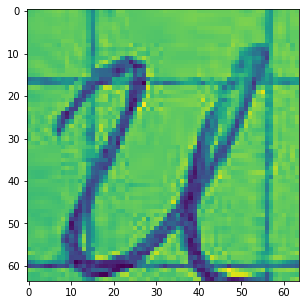

In [46]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
img = itr['image']
print("Class name: {}".format(label[0]))

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img[0])

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]

In [0]:
!mkdir results

In [0]:
def name_to_int(data):

  switcher = {
      'A': 1,
      'B': 2,
      'C': 3,
      'A_small': 1,
      'P': 2,
      'u': 3
  }

  new_data = []

  for dt in data:
    new_data.append(switcher.get(dt))

  return new_data

def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [51]:
def train(train_loader, val_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  val_loss_hist = []

  other_train_loss_hist = []

  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_images_train = 0
    num_other_images_train = 0

    # TRAINING DATASET
    correct = 0
    other_correct = 0
    for data in train_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.repeat(-10, num_of_classes)
        real_value[labels[idx] - 1] = 10
        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 
        
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()

    # TRAINING FOR OTHER DATASET
    for data in other_train_loader:
      images = data['image']

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        real_value = np.repeat(-10, num_of_classes)
        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 

        loss.backward()

        lossSum += loss.item()
        other_train_loss_hist.append(lossSum)

        optimizer.step()

    # VALIDATION
    for data in val_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      num_images_train = len(images)

      images.cuda()
      labels.cuda()

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        if(labels[idx] == get_max_from_tensor(outputs)):
          correct += 1

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.repeat(-10, num_of_classes)
        real_value[labels[idx] - 1] = 10
        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 

        lossSum += loss.item()
        val_loss_hist.append(lossSum)

    print("Epoch: {} Training loss: {} Eval loss: {} Other DB loss: {} Correct: {}%".format(epoch,train_loss_hist[len(train_loss_hist) - 1],val_loss_hist[len(val_loss_hist) - 1], other_train_loss_hist[len(other_train_loss_hist) - 1], correct*100/num_images_train))

    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

train(train_loader, val_loader, 100, 5)

Epoch: 0 Training loss: 114.42918194574304 Eval loss: 2212.9756841659546 Other DB loss: 97.71259162807837 Correct: 94.23076923076923%
Epoch: 1 Training loss: 71.92230873450171 Eval loss: 1997.779197216034 Other DB loss: 72.45333271900745 Correct: 96.15384615384616%
Epoch: 2 Training loss: 71.07659706799313 Eval loss: 2263.4120330810547 Other DB loss: 89.64779103494948 Correct: 96.15384615384616%
Epoch: 3 Training loss: 71.74783298769034 Eval loss: 2097.365608215332 Other DB loss: 86.39182806853205 Correct: 96.15384615384616%
Epoch: 4 Training loss: 64.35707801708486 Eval loss: 2138.2968349456787 Other DB loss: 68.94865710195154 Correct: 92.3076923076923%
Epoch: 5 Training loss: 73.3557187205879 Eval loss: 2043.0120396614075 Other DB loss: 85.2652824819088 Correct: 92.3076923076923%
Epoch: 6 Training loss: 65.09670756815467 Eval loss: 2507.395721435547 Other DB loss: 81.8894663839601 Correct: 94.23076923076923%
Epoch: 7 Training loss: 87.31569157540798 Eval loss: 2077.120063304901 Other

In [52]:
empty_image = io.imread('/content/Lithuanian_OCR/Data/white.jpg')
empty_image = rgb2gray(empty_image)
output = network(torch.Tensor(empty_image).cuda().flatten().float())
print(output)
print(get_max_from_tensor(output))
print(output[get_max_from_tensor(output) - 1])

prob_treshold = output[get_max_from_tensor(output) - 1].item()
print(prob_treshold)

tensor([-12.6193, -12.6144, -12.6665], device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(-12.6144, device='cuda:0', grad_fn=<SelectBackward>)
-12.614389419555664


In [53]:
lowest_prob = 100

for data in test_loader:
  images = data['image']
  labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

  for i in range(len(images)):
    output = network(images[i].cuda().flatten().float())
    
    prob = output[get_max_from_tensor(output) - 1]
    if prob < lowest_prob:
      lowest_prob = prob

    if(get_max_from_tensor(output) == labels[i] and prob > prob_treshold):
      print("OK: {} == {} Probability: {}".format(get_max_from_tensor(output), labels[i], prob))
    elif(prob < prob_treshold):
      print("False: Detected empty image on {} with probability: {}".format(labels[i], prob))
    else:
      print("False: {} == {} Probability: {}".format(get_max_from_tensor(output), labels[i], prob))

print("Lowest Probability: {}".format(lowest_prob))

OK: 1 == 1 Probability: 3.791440725326538
OK: 2 == 2 Probability: 11.007643699645996
OK: 3 == 3 Probability: 10.806563377380371
OK: 3 == 3 Probability: -4.572048187255859
OK: 1 == 1 Probability: 1.8658196926116943
OK: 1 == 1 Probability: -5.695376396179199
OK: 3 == 3 Probability: -0.6543677449226379
OK: 3 == 3 Probability: -4.850577354431152
OK: 2 == 2 Probability: 4.363203525543213
OK: 2 == 2 Probability: -2.3179800510406494
OK: 2 == 2 Probability: 8.32432746887207
OK: 3 == 3 Probability: 8.772372245788574
OK: 1 == 1 Probability: 4.737860679626465
OK: 2 == 2 Probability: 9.495803833007812
OK: 2 == 2 Probability: -2.3339104652404785
OK: 2 == 2 Probability: 8.831820487976074
OK: 1 == 1 Probability: 10.151124000549316
OK: 3 == 3 Probability: -1.2319812774658203
OK: 1 == 1 Probability: 5.030946731567383
OK: 1 == 1 Probability: 3.999912977218628
OK: 2 == 2 Probability: 14.44632625579834
OK: 3 == 3 Probability: 2.9137094020843506
OK: 2 == 2 Probability: 12.581581115722656
Lowest Probability

In [0]:
for opt in optimizer.param_groups:
  opt['lr'] = 0.00001

In [0]:
!cp '/content/results/model.pth' '/content/Lithuanian_OCR/Trained_model/model.pth'
!cp '/content/results/optimizer.pth' '/content/Lithuanian_OCR/Trained_model/optimizer.pth'